<a href="https://colab.research.google.com/github/drewwint/Quant-Family-Collective-fMRI-stats/blob/main/DWinters_QFC_wb5_rest_second_level_connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resting-state fMRI: Second-level analysis

In the following tutorial we will examine brain patterns across multiple participants in relation to a phenotype (simulated) or grouping variable (here we use gender).

For simplicity, we will focus on network connectivity of the DMN and seed to voxel connectivity by averaging connectivity and running a regression. This was intentional to have a basis of already covered statistical appraoches in prior presentations - there are many extensions we are covering such as whole-brian machine learning approaches to predict a given phenotype. Additionally, other extensions not covered involve topological network properties such as node centrality or connection efficiency.

Here we will start with downloading our data, creating spheres to extract timeseries and estimate connectivity, then running a regression to examine phenotypic and gender assocaitions.

In [ ]:
import numpy as np
! pip install nilearn &> /dev/null
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_connectome
import matplotlib.pyplot as plt

atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=20)

# print basic information on the dataset
print(f"First subject functional nifti images (4D) are at: {data.func[0]}")

Simulating a phenotype value for each participant

In [2]:
np.random.seed(123)
px = np.random.normal(loc=2.5,scale=1, size=20)

examining the distribution of the simulated phenotype

(array([1., 1., 1., 4., 3., 2., 1., 3., 2., 2.]),
 array([0.07332076, 0.53658169, 0.99984262, 1.46310355, 1.92636449,
        2.38962542, 2.85288635, 3.31614728, 3.77940822, 4.24266915,
        4.70593008]),
 <BarContainer object of 10 artists>)

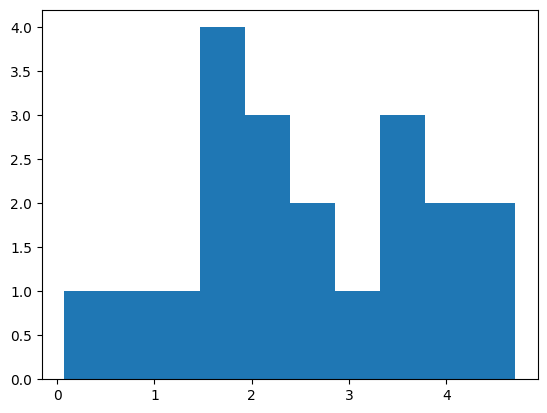

In [3]:
plt.hist(px)

In [31]:
pd.DataFrame(px).describe().T

,count,mean,std,min,25%,50%,75%,max
0,20.0,2.614418,1.257453,0.073321,1.851102,2.238189,3.569524,4.70593


# Default mode network (DMN)

We will start by extracting timeseries for the coordinates representnig the DMN and average DMN connectivity for each individual then run inferential statistics to examine brain patterns across participants in relation to phenotype and gender.

creating spheres for the DMN

In [4]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    "Posterior Cingulate Cortex",
    "Left Temporoparietal junction",
    "Right Temporoparietal junction",
    "Medial prefrontal cortex",
]

### Extracting timeseries for the DMN for each individual brain.

Becasue we have multiple participants - we will create a function that will extract each individuals DMN timeseries separately and place those in an list we call ts (short for timeseries)

we will then write other functions to estimate connectivity in a similar way. While we could do all of this in one function - We intentionally do this separately here for demonstration purposes.

In [ ]:
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    dmn_coords,
    radius=8,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=2,
    clean__butterworth__padtype="even",  # kwarg to modify Butterworth filter
)

# Additionally, we pass confound information to ensure our extracted
# signal is cleaned from confounds.

ts = []
for i in range(len(data.func)):
  func_filename = data.func[i]
  confounds_filename = data.confounds[i]
  ts.append(masker.fit_transform(
      func_filename,
      confounds=[confounds_filename]
      )
  )



Here I am just making sure we have 20 participants in our extracted timeseries. It is good practice to create these tests after running a command to ensure your data is behaving as expected.

In [6]:
len(ts) == 20

True

### Estimating connectivity of the DMN for each individual

like we did above - we create a function to estimate connectivity for each individual separately and place these estimates in a list called dmn_matrix.

In [ ]:
dmn_matrix = []
correlation_measure = ConnectivityMeasure(kind='correlation')
for i in range(len(data.func)):
  dmn_matrix.append(correlation_measure.fit_transform([ts[i]])[0])


In [8]:
len(dmn_matrix) == 20

True

### Extracting average connectivity of the DMN for each participant

In [9]:
dmn_ave = []
for i in range(len(data.func)):
  dmn_ave.append(np.average(dmn_matrix[i]))

In [10]:
len(dmn_ave) == 20

True

examining distribution of DMN connectivity

(array([1., 1., 1., 2., 4., 4., 3., 0., 1., 3.]),
 array([0.27815601, 0.31383987, 0.34952374, 0.38520761, 0.42089148,
        0.45657534, 0.49225921, 0.52794308, 0.56362694, 0.59931081,
        0.63499468]),
 <BarContainer object of 10 artists>)

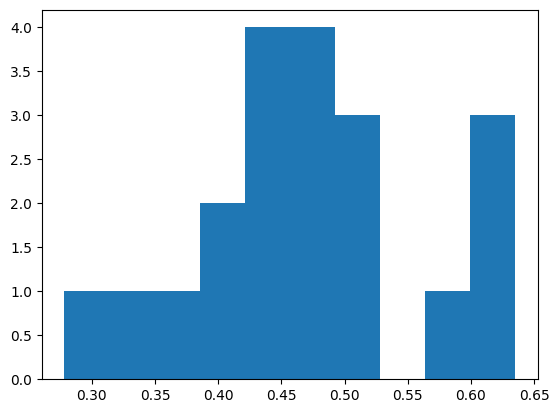

In [11]:
plt.hist(dmn_ave)

In [32]:
pd.DataFrame(dmn_ave).describe().T

,count,mean,std,min,25%,50%,75%,max
0,20.0,0.472045,0.094187,0.278156,0.424674,0.463486,0.518309,0.634995


### Inferential (second-level) statistics on DMN

Here we will just run a regression between DMN and gender to demonstrate a connectiviy second-level analysis.

#### Phenotype and DMN

In [12]:
import statsmodels.api as sm
# x = sm.add_constant(pd.DataFrame(px))
mod = sm.OLS(dmn_ave, px)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.775
Method:                 Least Squares   F-statistic:                              69.81
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                    8.74e-08
Time:                        17:08:28   Log-Likelihood:                          1.6844
No. Observations:                  20   AIC:                                     -1.369
Df Residuals:                      19   BIC:                                    -0.3731
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Plotting DMN Phenotype association
here we will extract each node connection from each participants brain then estimate a correlation value for each DMN connection with the estimated phenotype and plot what that on a glass brain.

Lets start with extracting each connection for each participant using the following function

In [88]:
dmn_con = []
for i in dmn_matrix:
  dt = []
  for j in i:
    for jj in j:
      dt.append(jj)
  dmn_con.append(dt)


then we will estimate a correlation value for each individual connection in the DMN

In [ ]:
cor_px = []
for i in range(len(dmn_con[0])):
  cp = []
  for j in dmn_con:
    cp.append(j[i])
  cor_px.append(np.corrcoef(cp, px)[0,1])

Now we need to shape our findings into a matrix for plotting

In [282]:
a = np.array(cor_px)
a = np.matrix(a.reshape([4,4]))
np.fill_diagonal(a,0)
a = np.arctanh(a) * 1.5 # fishers to z score and scaled

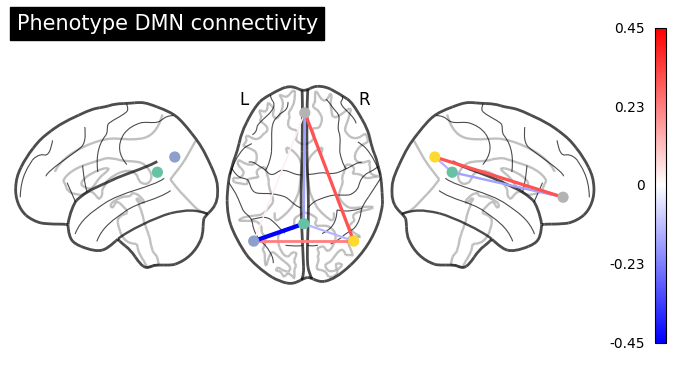

In [263]:
import nilearn

nilearn.plotting.plot_connectome(np.array(a),
                                 dmn_coords,
                                 title = "Phenotype DMN connectivity",
                                 colorbar=True,
                                 display_mode='lzr',
                                 edge_vmin=-0.45,
                                 edge_vmax=0.45)

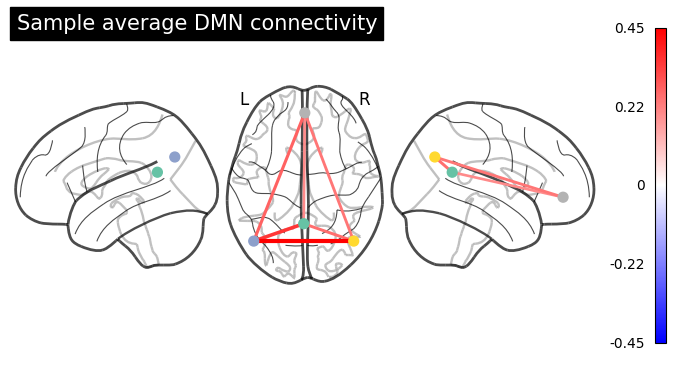

In [283]:
nilearn.plotting.plot_connectome(np.average(dmn_matrix, axis = 0),
                                 dmn_coords,
                                 title = "Sample average DMN connectivity",
                                 colorbar=True,
                                 display_mode='lzr')

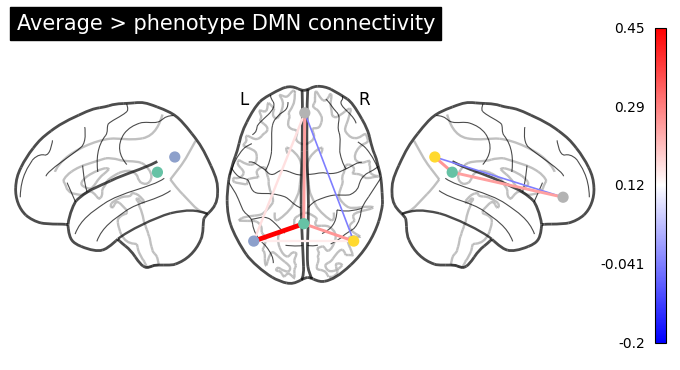

In [287]:
nilearn.plotting.plot_connectome((((abs(np.min(np.array(a))) + np.average(dmn_matrix, axis = 0)) - (abs(np.min(np.array(a))) + np.array(a)))/1.5),
                                 dmn_coords,
                                 title = "Average > phenotype DMN connectivity",
                                 colorbar=True,
                                 display_mode='lzr',
                                 edge_vmin=-np.min(np.average(dmn_matrix, axis = 0)),
                                 edge_vmax=0.45)

Now we can see the phenotype associates with an anticorrelation between the left TPJ and PCC as well as PCC to MPFC, heightened connectivity betweenbilateral TPJ and right TPJ to mPFC, and no connectivity between left TPJ and mPFC.

where the overall average of the sample is positive -- but when we look at the contrast of the average > phenotype we see that the phenotype has an extraordinarily high connectivity in the right hemisphere, an extra ordinarily low connection between the left TPJ nad PCC, and all the other connectiosn are about equivelant.

This can help us beter understand where the phenotype associates with differences in the DMN as well as the specific connections that may be different.

You may also note that the overall connectivity of the DMN associates positiely with this phenotype - BUT we see a very different picture when we look at the individual connections. This is likely a difference in an overall omnibus test  glossing over important individual associations that may better characterize a given phenotype. This may be relevant for a number of statistical approaches out side of the brain such as averaging items for a self-report measure. Where an overall score may say one thing there may be individual indicator differences that a particularly meaninful.

If we were to interpret this we could say higher DMN connectivity associates with this phenotype AND this appears to be driven by right TPJ to mPFC connectivity. But we would likely want to follow up with additional tests to better characterize this association on individual connections to better characterize our phenotype.

We will leave this here for now and move on to a group analysis

#### Gender and DMN

first we have to recode our gender varaible into numbers before running our regression.

In [13]:
gend = list(data.phenotypic['Gender']).copy()

gend_r = []
for i in gend:
  if i == 'M':
    gend_r.append(1)
  else:
    gend_r.append(0)

comparing string gender with numerical gender

In [33]:

import pandas as pd
pd.DataFrame({"letter":gend,"num":gend_r}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
letter,F,M,M,F,M,F,F,F,F,F,M,F,M,M,F,F,M,M,F,M
num,0,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1


seems to have worked as expected

#### Running the regression with gender

In [15]:
# x = sm.add_constant(pd.DataFrame(gend_r))
mod = sm.OLS(dmn_ave, gend_r)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.407
Method:                 Least Squares   F-statistic:                              14.75
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                     0.00110
Time:                        17:08:28   Log-Likelihood:                         -7.9923
No. Observations:                  20   AIC:                                      17.98
Df Residuals:                      19   BIC:                                      18.98
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

in this case we can see that males relative to females have more DMN connectivity *on average*.

#### Plotting gender effects
We can plot this effect usign a violin plot.

*note we are not using a barplot because they are known for hiding the distribution of the data and inaccurate representations of the data* if you are intersted in this see [this paper](https://doi.org/10.1371/journal.pbio.1002128) and [this add](https://www.kickstarter.com/projects/1474588473/barbarplots)

In [148]:
x = pd.DataFrame({"gend":gend_r, "pheno": px, "dmn":dmn_ave})

In [150]:
male_dmn= x.dmn[np.where(x.gend == 1)[0]]
female_dmn= x.dmn[np.where(x.gend == 0)[0]]

<Axes: xlabel='gend', ylabel='dmn'>

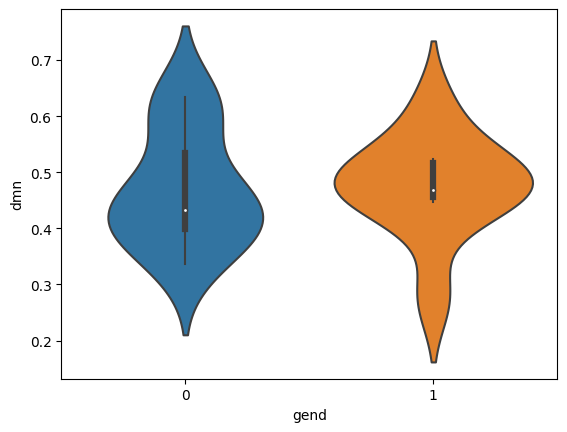

In [177]:
import seaborn as sns
sns.violinplot(data=x, x="gend", y="dmn", inner = "box")

we can see that the males have a less wide distribution that retains a slightly higher average DMN connectivity but there is much more variance in females. We could doe some permutation testing to bolster our confidence in this but we will leave this as is for now

### Both phenotype and gender

In [138]:
x = pd.DataFrame({"gend":gend_r, "pheno": px}) # could add an interaction: , "interact": gend_r * px
mod = sm.OLS(dmn_ave, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              33.18
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                    9.16e-07
Time:                        18:29:37   Log-Likelihood:                          1.7120
No. Observations:                  20   AIC:                                     0.5760
Df Residuals:                      18   BIC:                                      2.567
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

It appears that when accounting for phenotype - gender no longer is a significant assoication - but the phenotype finding holds.


## Seed to voxel correlation

Here what we want to know how the magnitude of Posterior Cingulate Cortex (PCC) connectivity with the rest of the brain assocaites with phenotype and gender.

We will estimate connectiviy of  our PCC seed with voxels across the entire brain and average the connectivity of the PCC for each individual then run second-level analyses to examine pattern level associations across participants.


### Extracting seed timeseries

In [17]:
pcc_coords = [(0, -52, 18)]

from nilearn.maskers import NiftiSpheresMasker

seed_masker = NiftiSpheresMasker(
    pcc_coords,
    radius=8,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)


seed_time_series = []
for i in range(len(data.func)):
  func_filename = data.func[i]
  confounds_filename = data.confounds[i]
  seed_time_series.append(seed_masker.fit_transform(
      func_filename,
      confounds=[confounds_filename]
      )
  )



### Extracting timeseries across the entire brain

In [18]:
from nilearn.maskers import NiftiMasker

brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)


brain_time_series = []
for i in range(len(data.func)):
  func_filename = data.func[i]
  confounds_filename = data.confounds[i]
  brain_time_series.append(brain_masker.fit_transform(
      func_filename,
      confounds=[confounds_filename]
      )
  )



### Estimating PCC connectivity

In [19]:
import numpy as np


seed_to_voxel_correlations = []
for i in range(len(data.func)):
  bt = brain_time_series[i].T
  st = seed_time_series[i]
  seed_to_voxel_correlations.append(
    np.arctanh(np.dot(bt, st) / st.shape[0]
               )
    )




test to ensure we have 20 participants

In [20]:
len(seed_to_voxel_correlations)==20

True

### Averaging PCC connectivity for each participant

In [21]:
seed_ave = []
for i in range(len(data.func)):
  seed_ave.append(np.average(seed_to_voxel_correlations[i]))

In [22]:
len(seed_ave)==20

True

### Phenotype and PCC connectivity

In [23]:
mod = sm.OLS(seed_ave, px)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.582
Method:                 Least Squares   F-statistic:                              28.84
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                    3.50e-05
Time:                        17:12:22   Log-Likelihood:                          34.971
No. Observations:                  20   AIC:                                     -67.94
Df Residuals:                      19   BIC:                                     -66.95
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Gender and PCC connectivity

In [24]:
mod = sm.OLS(seed_ave, gend_r)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.429
Model:                            OLS   Adj. R-squared (uncentered):              0.399
Method:                 Least Squares   F-statistic:                              14.25
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                     0.00128
Time:                        17:12:22   Log-Likelihood:                          31.332
No. Observations:                  20   AIC:                                     -60.66
Df Residuals:                      19   BIC:                                     -59.67
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Gender and phenotype with PCC connectivity

In [25]:
x = pd.DataFrame({"gend":gend_r, "pheno": px}) #Could add interaction: , "interact": gend_r * px}
mod = sm.OLS(seed_ave, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.620
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                              14.69
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                    0.000165
Time:                        17:12:22   Log-Likelihood:                          35.416
No. Observations:                  20   AIC:                                     -66.83
Df Residuals:                      18   BIC:                                     -64.84
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Conclusion
Now you should have a sense for how to conduct second-level analyses with functional connectivity data.

Again - there are many extensions of these approaches we are not covering but these are the basics to build intuition for running anlayses on fMRI data.

We can expand these appraoches in later tutorials (so look out for more in the future).
